In [1]:
!pip install segmentation_models_pytorch warmup_scheduler albumentations -q


In [2]:
import os
import sys
import random
from glob import glob
import warnings

import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

sys.path.append('/kaggle/working/notebook/experiment/2d')
from script.helper import *
from script.dataset import *
from script.metrics import *
from script.trainer import *
from script.model import *
from script.loss import *
from script.scheduler import *


## config

In [3]:
class ExtractLayers(A.ImageOnlyTransform):
    def __init__(self, in_channels, out_channels, is_train=True, always_apply=False, p=1):
        super(ExtractLayers, self).__init__(always_apply, p)
        self.is_train = is_train
        self.in_channels = in_channels
        self.out_channels = out_channels

    def apply(self, img, **params):
        if self.is_train:
            start = random.randint(0, self.in_channels-self.out_channels)
            end = start+self.out_channels
            img = img[:, :, start:end]
        else:
            img = img[:, :, 3:3+self.out_channels]
        return img


In [4]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    dataset_path = "/kaggle/working/dataset_train/"
    train_dataset_path = "/kaggle/working/dataset_train/nonflatten/25-37/"
    dataset_range = train_dataset_path.split("/")[-2]
    
    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'se_resnext50_32x4d'
    in_chans = 8

    # ============== pred target =============
    target_size = 1

    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16  # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'

    epochs = 20  # 15

    warmup_factor = 10
    lr = 1e-4 / warmup_factor
    loss="bce_dice_loss"
    
    # ============== fold =============
    metric_direction = 'maximize'  # maximize, 'minimize'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                        mask_fill_value=0, p=0.5),
        ExtractLayers(13, in_chans, is_train=True),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        ExtractLayers(13, in_chans, is_train=False),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True  # type: ignore

set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)


## Dataset

In [5]:
def preprocess(image, fragment_i, split_i):
    # topography = cv2.imread(f"{CFG.dataset_path}/topography_{fragment_i}_{split_i}.png",-1)
    # topography = topography.astype("uint16")*1057
    # pad0 = (CFG.tile_size - topography.shape[0] % CFG.tile_size)
    # pad1 = (CFG.tile_size - topography.shape[1] % CFG.tile_size)
    # topography = np.pad(topography, [(0, pad0), (0, pad1)], constant_values=0)
    # topography = np.expand_dims(topography, axis=2)
    # image=np.concatenate([image,topography], axis=2)
    return image



len(train_images) = 14624
train_images[0].shape = (224, 224, 13)
train_labels[0].shape = (224, 224, 1)
train_masks[0].shape = (224, 224, 1)

len(valid_images) = 4161
valid_images[0].shape = (224, 224, 13)
valid_labels[0].shape = (224, 224, 1)



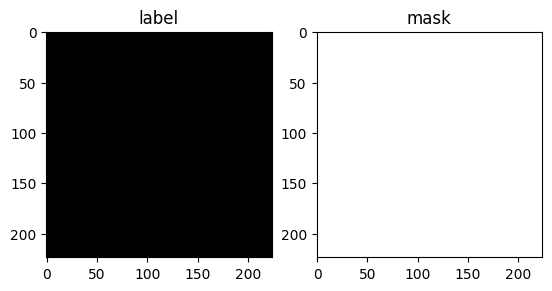

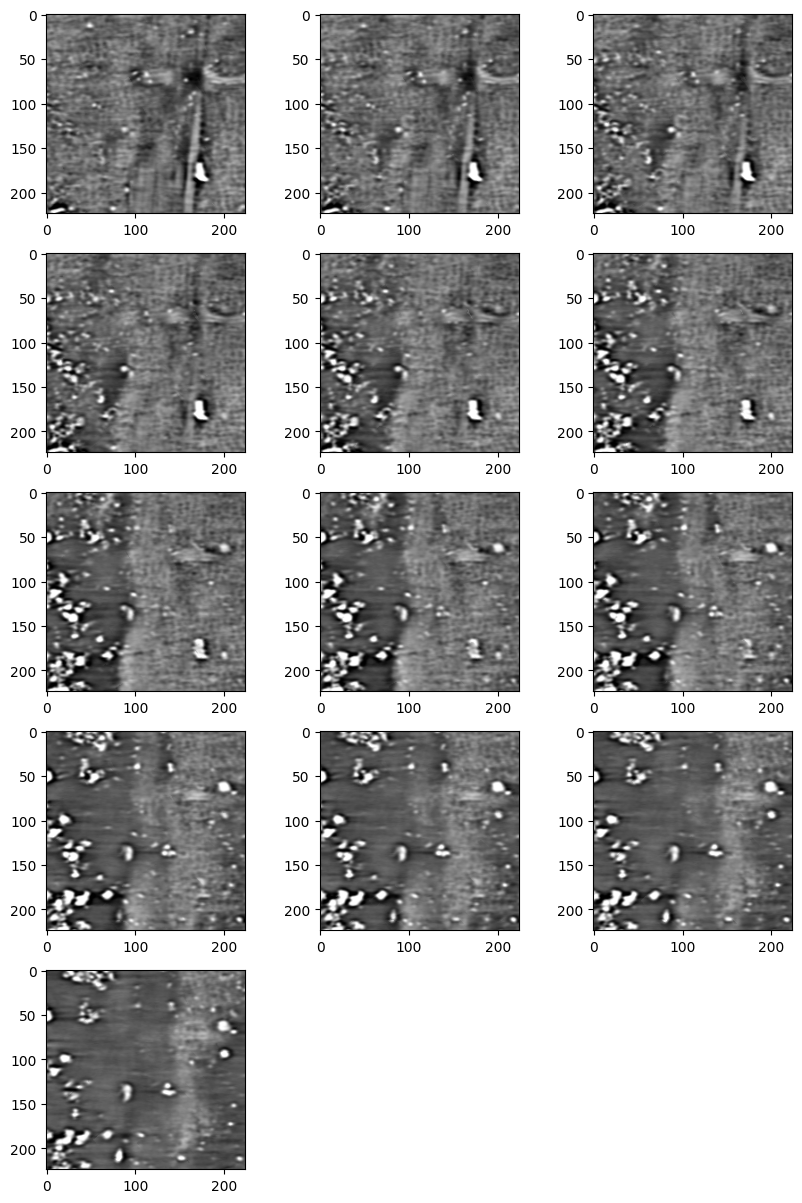

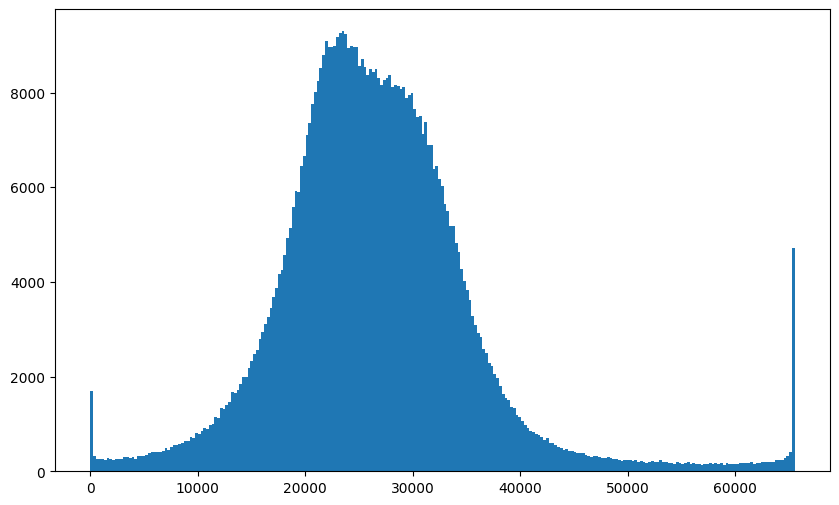

In [6]:
# confirmation

valid_fragment_i = 1
valid_split_i = 0

train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess)

print(f"""
{len(train_images) = }
{train_images[0].shape = }
{train_labels[0].shape = }
{train_masks[0].shape = }

{len(valid_images) = }
{valid_images[0].shape = }
{valid_labels[0].shape = }
""")

id = random.randint(0, len(train_labels))
visualize_train_images(id, train_images, train_labels, train_masks)


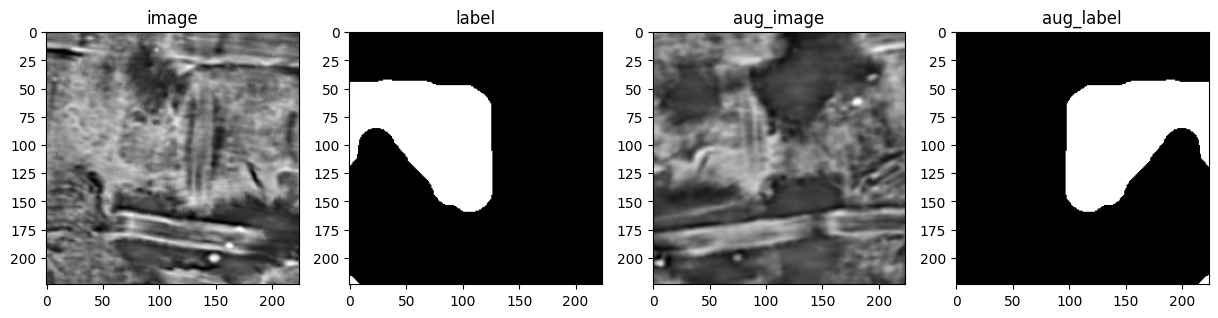

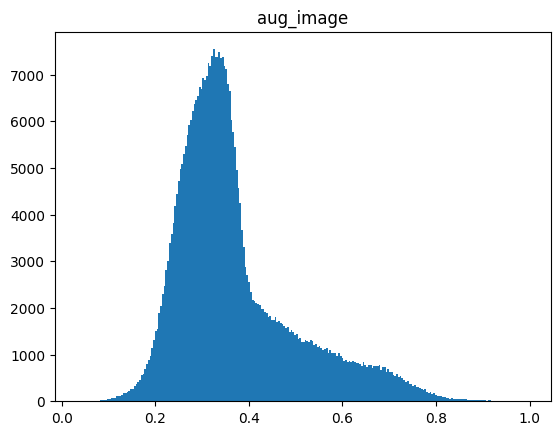

In [7]:
# confirmation
plot_dataset = CustomDataset(train_images, CFG, labels=train_labels)
visualize_dataset(plot_dataset, CFG)


## main

In [8]:
train_and_evaluate(preprocess, CFG)
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！' https://notify-api.line.me/api/notify

fold: 0


100%|██████████| 131/131 [00:08<00:00, 15.62it/s]


fbeta: 0.3874
Epoch 1 - avg_train_loss: 1.3628  avg_val_loss: 1.0610  avgScore: 0.3874  time: 109s
Epoch 1 - Save Best Loss: 1.0610  Best Score: 0.3874 Model



100%|██████████| 131/131 [00:06<00:00, 21.81it/s]


fbeta: 0.3603
Epoch 2 - avg_train_loss: 1.1656  avg_val_loss: 1.0640  avgScore: 0.3603  time: 81s



100%|██████████| 131/131 [00:06<00:00, 21.78it/s]


fbeta: 0.4542
Epoch 3 - avg_train_loss: 1.0033  avg_val_loss: 0.9103  avgScore: 0.4542  time: 79s
Epoch 3 - Save Best Loss: 0.9103  Best Score: 0.4542 Model



100%|██████████| 131/131 [00:05<00:00, 22.07it/s]


fbeta: 0.3951
Epoch 4 - avg_train_loss: 0.9071  avg_val_loss: 0.9322  avgScore: 0.3951  time: 77s



100%|██████████| 131/131 [00:06<00:00, 21.74it/s]


fbeta: 0.4823
Epoch 5 - avg_train_loss: 0.8574  avg_val_loss: 0.8445  avgScore: 0.4823  time: 77s
Epoch 5 - Save Best Loss: 0.8445  Best Score: 0.4823 Model



100%|██████████| 131/131 [00:05<00:00, 21.84it/s]


fbeta: 0.4089
Epoch 6 - avg_train_loss: 0.8205  avg_val_loss: 0.9494  avgScore: 0.4089  time: 76s



100%|██████████| 131/131 [00:05<00:00, 22.44it/s]


fbeta: 0.4321
Epoch 7 - avg_train_loss: 0.7986  avg_val_loss: 0.9148  avgScore: 0.4321  time: 77s



100%|██████████| 131/131 [00:05<00:00, 22.43it/s]


fbeta: 0.4745
Epoch 8 - avg_train_loss: 0.7491  avg_val_loss: 0.8791  avgScore: 0.4745  time: 74s



100%|██████████| 131/131 [00:05<00:00, 22.49it/s]


fbeta: 0.5108
Epoch 9 - avg_train_loss: 0.7174  avg_val_loss: 0.8772  avgScore: 0.5108  time: 74s
Epoch 9 - Save Best Loss: 0.8772  Best Score: 0.5108 Model



100%|██████████| 131/131 [00:05<00:00, 22.39it/s]


fbeta: 0.4914
Epoch 10 - avg_train_loss: 0.7190  avg_val_loss: 0.9100  avgScore: 0.4914  time: 74s



100%|██████████| 131/131 [00:05<00:00, 22.45it/s]


fbeta: 0.4514
Epoch 11 - avg_train_loss: 0.7029  avg_val_loss: 0.9036  avgScore: 0.4514  time: 73s



100%|██████████| 131/131 [00:05<00:00, 22.36it/s]


fbeta: 0.4932
Epoch 12 - avg_train_loss: 0.6745  avg_val_loss: 0.8959  avgScore: 0.4932  time: 74s



100%|██████████| 131/131 [00:05<00:00, 22.40it/s]


fbeta: 0.4143
Epoch 13 - avg_train_loss: 0.6512  avg_val_loss: 0.9379  avgScore: 0.4143  time: 75s



100%|██████████| 131/131 [00:05<00:00, 22.46it/s]


fbeta: 0.5036
Epoch 14 - avg_train_loss: 0.6212  avg_val_loss: 0.8603  avgScore: 0.5036  time: 73s



100%|██████████| 131/131 [00:05<00:00, 22.45it/s]


fbeta: 0.5126
Epoch 15 - avg_train_loss: 0.6114  avg_val_loss: 0.9060  avgScore: 0.5126  time: 75s
Epoch 15 - Save Best Loss: 0.9060  Best Score: 0.5126 Model



100%|██████████| 131/131 [00:05<00:00, 22.42it/s]


fbeta: 0.4962
Epoch 16 - avg_train_loss: 0.5891  avg_val_loss: 0.9057  avgScore: 0.4962  time: 74s



100%|██████████| 131/131 [00:05<00:00, 22.42it/s]


fbeta: 0.5423
Epoch 17 - avg_train_loss: 0.5778  avg_val_loss: 0.8647  avgScore: 0.5423  time: 73s
Epoch 17 - Save Best Loss: 0.8647  Best Score: 0.5423 Model



100%|██████████| 131/131 [00:05<00:00, 22.41it/s]


fbeta: 0.4935
Epoch 18 - avg_train_loss: 0.5543  avg_val_loss: 0.9079  avgScore: 0.4935  time: 74s



100%|██████████| 131/131 [00:05<00:00, 22.46it/s]


fbeta: 0.5351
Epoch 19 - avg_train_loss: 0.5444  avg_val_loss: 0.9105  avgScore: 0.5351  time: 74s



100%|██████████| 131/131 [00:05<00:00, 22.44it/s]


fbeta: 0.5159
Epoch 20 - avg_train_loss: 0.5338  avg_val_loss: 0.9193  avgScore: 0.5159  time: 74s

fold: 1


100%|██████████| 120/120 [00:05<00:00, 21.59it/s]


fbeta: 0.3734
Epoch 1 - avg_train_loss: 1.4308  avg_val_loss: 0.9260  avgScore: 0.3734  time: 74s
Epoch 1 - Save Best Loss: 0.9260  Best Score: 0.3734 Model



100%|██████████| 120/120 [00:05<00:00, 21.31it/s]


fbeta: 0.3984
Epoch 2 - avg_train_loss: 1.2350  avg_val_loss: 0.8879  avgScore: 0.3984  time: 74s
Epoch 2 - Save Best Loss: 0.8879  Best Score: 0.3984 Model



100%|██████████| 120/120 [00:05<00:00, 21.45it/s]


fbeta: 0.4865
Epoch 3 - avg_train_loss: 1.0537  avg_val_loss: 0.6556  avgScore: 0.4865  time: 74s
Epoch 3 - Save Best Loss: 0.6556  Best Score: 0.4865 Model



100%|██████████| 120/120 [00:05<00:00, 21.74it/s]


fbeta: 0.5140
Epoch 4 - avg_train_loss: 0.9079  avg_val_loss: 0.6165  avgScore: 0.5140  time: 73s
Epoch 4 - Save Best Loss: 0.6165  Best Score: 0.5140 Model



100%|██████████| 120/120 [00:05<00:00, 21.74it/s]


fbeta: 0.5052
Epoch 5 - avg_train_loss: 0.8664  avg_val_loss: 0.6206  avgScore: 0.5052  time: 73s



100%|██████████| 120/120 [00:05<00:00, 21.67it/s]


fbeta: 0.5686
Epoch 6 - avg_train_loss: 0.8420  avg_val_loss: 0.6387  avgScore: 0.5686  time: 73s
Epoch 6 - Save Best Loss: 0.6387  Best Score: 0.5686 Model



100%|██████████| 120/120 [00:05<00:00, 21.80it/s]


fbeta: 0.5178
Epoch 7 - avg_train_loss: 0.8088  avg_val_loss: 0.6043  avgScore: 0.5178  time: 73s



100%|██████████| 120/120 [00:05<00:00, 21.87it/s]


fbeta: 0.5925
Epoch 8 - avg_train_loss: 0.7808  avg_val_loss: 0.5982  avgScore: 0.5925  time: 72s
Epoch 8 - Save Best Loss: 0.5982  Best Score: 0.5925 Model



100%|██████████| 120/120 [00:05<00:00, 21.85it/s]


fbeta: 0.5513
Epoch 9 - avg_train_loss: 0.7514  avg_val_loss: 0.6275  avgScore: 0.5513  time: 73s



100%|██████████| 120/120 [00:05<00:00, 21.91it/s]


fbeta: 0.5062
Epoch 10 - avg_train_loss: 0.7301  avg_val_loss: 0.5766  avgScore: 0.5062  time: 73s



100%|██████████| 120/120 [00:05<00:00, 21.68it/s]


fbeta: 0.5328
Epoch 11 - avg_train_loss: 0.7044  avg_val_loss: 0.5791  avgScore: 0.5328  time: 73s



100%|██████████| 120/120 [00:05<00:00, 21.71it/s]


fbeta: 0.5398
Epoch 12 - avg_train_loss: 0.6614  avg_val_loss: 0.5948  avgScore: 0.5398  time: 73s



100%|██████████| 120/120 [00:05<00:00, 21.71it/s]


fbeta: 0.5530
Epoch 13 - avg_train_loss: 0.6434  avg_val_loss: 0.5882  avgScore: 0.5530  time: 73s



100%|██████████| 120/120 [00:05<00:00, 21.73it/s]


fbeta: 0.5945
Epoch 14 - avg_train_loss: 0.6251  avg_val_loss: 0.5895  avgScore: 0.5945  time: 73s
Epoch 14 - Save Best Loss: 0.5895  Best Score: 0.5945 Model



100%|██████████| 120/120 [00:05<00:00, 21.72it/s]


fbeta: 0.5920
Epoch 15 - avg_train_loss: 0.5943  avg_val_loss: 0.5874  avgScore: 0.5920  time: 74s



100%|██████████| 120/120 [00:05<00:00, 21.70it/s]


fbeta: 0.6067
Epoch 16 - avg_train_loss: 0.5685  avg_val_loss: 0.5889  avgScore: 0.6067  time: 73s
Epoch 16 - Save Best Loss: 0.5889  Best Score: 0.6067 Model



100%|██████████| 120/120 [00:05<00:00, 21.68it/s]


fbeta: 0.5577
Epoch 17 - avg_train_loss: 0.5520  avg_val_loss: 0.5839  avgScore: 0.5577  time: 73s



100%|██████████| 120/120 [00:05<00:00, 21.85it/s]


fbeta: 0.5817
Epoch 18 - avg_train_loss: 0.5441  avg_val_loss: 0.5989  avgScore: 0.5817  time: 72s



100%|██████████| 120/120 [00:05<00:00, 21.70it/s]


fbeta: 0.6071
Epoch 19 - avg_train_loss: 0.5315  avg_val_loss: 0.6087  avgScore: 0.6071  time: 73s
Epoch 19 - Save Best Loss: 0.6087  Best Score: 0.6071 Model



100%|██████████| 120/120 [00:05<00:00, 21.71it/s]


fbeta: 0.6026
Epoch 20 - avg_train_loss: 0.5178  avg_val_loss: 0.6059  avgScore: 0.6026  time: 73s

fold: 2


100%|██████████| 120/120 [00:05<00:00, 21.72it/s]


fbeta: 0.3821
Epoch 1 - avg_train_loss: 1.1442  avg_val_loss: 1.1698  avgScore: 0.3821  time: 73s
Epoch 1 - Save Best Loss: 1.1698  Best Score: 0.3821 Model



100%|██████████| 120/120 [00:05<00:00, 21.18it/s]


fbeta: 0.4407
Epoch 2 - avg_train_loss: 1.0352  avg_val_loss: 1.0960  avgScore: 0.4407  time: 75s
Epoch 2 - Save Best Loss: 1.0960  Best Score: 0.4407 Model



100%|██████████| 120/120 [00:05<00:00, 21.24it/s]


fbeta: 0.4529
Epoch 3 - avg_train_loss: 0.9521  avg_val_loss: 1.0719  avgScore: 0.4529  time: 75s
Epoch 3 - Save Best Loss: 1.0719  Best Score: 0.4529 Model



100%|██████████| 120/120 [00:05<00:00, 21.19it/s]


fbeta: 0.5292
Epoch 4 - avg_train_loss: 0.8583  avg_val_loss: 1.0519  avgScore: 0.5292  time: 75s
Epoch 4 - Save Best Loss: 1.0519  Best Score: 0.5292 Model



100%|██████████| 120/120 [00:05<00:00, 21.35it/s]


fbeta: 0.4947
Epoch 5 - avg_train_loss: 0.8286  avg_val_loss: 1.0552  avgScore: 0.4947  time: 75s



100%|██████████| 120/120 [00:05<00:00, 21.91it/s]


fbeta: 0.5172
Epoch 6 - avg_train_loss: 0.8134  avg_val_loss: 1.1012  avgScore: 0.5172  time: 74s



100%|██████████| 120/120 [00:05<00:00, 21.29it/s]


fbeta: 0.5577
Epoch 7 - avg_train_loss: 0.7552  avg_val_loss: 1.0020  avgScore: 0.5577  time: 74s
Epoch 7 - Save Best Loss: 1.0020  Best Score: 0.5577 Model



100%|██████████| 120/120 [00:05<00:00, 21.33it/s]


fbeta: 0.5744
Epoch 8 - avg_train_loss: 0.7492  avg_val_loss: 1.0242  avgScore: 0.5744  time: 75s
Epoch 8 - Save Best Loss: 1.0242  Best Score: 0.5744 Model



100%|██████████| 120/120 [00:05<00:00, 21.35it/s]


fbeta: 0.5788
Epoch 9 - avg_train_loss: 0.7173  avg_val_loss: 1.0415  avgScore: 0.5788  time: 75s
Epoch 9 - Save Best Loss: 1.0415  Best Score: 0.5788 Model



100%|██████████| 120/120 [00:05<00:00, 21.37it/s]


fbeta: 0.5613
Epoch 10 - avg_train_loss: 0.6909  avg_val_loss: 1.0258  avgScore: 0.5613  time: 75s



100%|██████████| 120/120 [00:05<00:00, 21.80it/s]


fbeta: 0.5635
Epoch 11 - avg_train_loss: 0.6739  avg_val_loss: 1.0855  avgScore: 0.5635  time: 73s



100%|██████████| 120/120 [00:05<00:00, 21.98it/s]


fbeta: 0.5967
Epoch 12 - avg_train_loss: 0.6500  avg_val_loss: 1.0732  avgScore: 0.5967  time: 72s
Epoch 12 - Save Best Loss: 1.0732  Best Score: 0.5967 Model



100%|██████████| 120/120 [00:05<00:00, 21.48it/s]


fbeta: 0.5774
Epoch 13 - avg_train_loss: 0.6331  avg_val_loss: 1.0714  avgScore: 0.5774  time: 74s



100%|██████████| 120/120 [00:05<00:00, 21.26it/s]


fbeta: 0.5708
Epoch 14 - avg_train_loss: 0.6085  avg_val_loss: 1.1177  avgScore: 0.5708  time: 74s



100%|██████████| 120/120 [00:05<00:00, 21.55it/s]


fbeta: 0.5714
Epoch 15 - avg_train_loss: 0.5976  avg_val_loss: 1.0770  avgScore: 0.5714  time: 74s



100%|██████████| 120/120 [00:05<00:00, 21.91it/s]


fbeta: 0.5733
Epoch 16 - avg_train_loss: 0.5755  avg_val_loss: 1.0495  avgScore: 0.5733  time: 74s



100%|██████████| 120/120 [00:05<00:00, 21.65it/s]


fbeta: 0.5910
Epoch 17 - avg_train_loss: 0.5517  avg_val_loss: 1.0686  avgScore: 0.5910  time: 73s



100%|██████████| 120/120 [00:05<00:00, 21.77it/s]


fbeta: 0.6042
Epoch 18 - avg_train_loss: 0.5287  avg_val_loss: 1.0762  avgScore: 0.6042  time: 73s
Epoch 18 - Save Best Loss: 1.0762  Best Score: 0.6042 Model



100%|██████████| 120/120 [00:05<00:00, 21.61it/s]


fbeta: 0.5960
Epoch 19 - avg_train_loss: 0.5309  avg_val_loss: 1.1065  avgScore: 0.5960  time: 73s



100%|██████████| 120/120 [00:05<00:00, 21.44it/s]


fbeta: 0.5916
Epoch 20 - avg_train_loss: 0.5114  avg_val_loss: 1.1229  avgScore: 0.5916  time: 74s

fold: 3


100%|██████████| 120/120 [00:05<00:00, 20.54it/s]


fbeta: 0.3746
Epoch 1 - avg_train_loss: 1.3770  avg_val_loss: 1.1064  avgScore: 0.3746  time: 75s
Epoch 1 - Save Best Loss: 1.1064  Best Score: 0.3746 Model



100%|██████████| 120/120 [00:05<00:00, 20.40it/s]


fbeta: 0.4414
Epoch 2 - avg_train_loss: 1.1405  avg_val_loss: 1.0358  avgScore: 0.4414  time: 75s
Epoch 2 - Save Best Loss: 1.0358  Best Score: 0.4414 Model



100%|██████████| 120/120 [00:06<00:00, 19.35it/s]


fbeta: 0.4114
Epoch 3 - avg_train_loss: 1.0079  avg_val_loss: 1.0180  avgScore: 0.4114  time: 77s



100%|██████████| 120/120 [00:06<00:00, 19.44it/s]


fbeta: 0.5627
Epoch 4 - avg_train_loss: 0.8694  avg_val_loss: 0.8748  avgScore: 0.5627  time: 81s
Epoch 4 - Save Best Loss: 0.8748  Best Score: 0.5627 Model



100%|██████████| 120/120 [00:06<00:00, 19.77it/s]


fbeta: 0.5022
Epoch 5 - avg_train_loss: 0.8618  avg_val_loss: 0.9194  avgScore: 0.5022  time: 79s



100%|██████████| 120/120 [00:05<00:00, 20.24it/s]


fbeta: 0.5437
Epoch 6 - avg_train_loss: 0.8120  avg_val_loss: 0.9196  avgScore: 0.5437  time: 76s



100%|██████████| 120/120 [00:05<00:00, 20.23it/s]


fbeta: 0.6004
Epoch 7 - avg_train_loss: 0.7941  avg_val_loss: 0.8773  avgScore: 0.6004  time: 76s
Epoch 7 - Save Best Loss: 0.8773  Best Score: 0.6004 Model



100%|██████████| 120/120 [00:05<00:00, 20.25it/s]


fbeta: 0.5633
Epoch 8 - avg_train_loss: 0.7824  avg_val_loss: 0.9238  avgScore: 0.5633  time: 76s



100%|██████████| 120/120 [00:05<00:00, 20.53it/s]


fbeta: 0.6020
Epoch 9 - avg_train_loss: 0.7567  avg_val_loss: 0.8569  avgScore: 0.6020  time: 75s
Epoch 9 - Save Best Loss: 0.8569  Best Score: 0.6020 Model



100%|██████████| 120/120 [00:05<00:00, 20.16it/s]


fbeta: 0.5967
Epoch 10 - avg_train_loss: 0.7042  avg_val_loss: 0.8994  avgScore: 0.5967  time: 76s



100%|██████████| 120/120 [00:05<00:00, 20.75it/s]


fbeta: 0.6230
Epoch 11 - avg_train_loss: 0.6787  avg_val_loss: 0.8754  avgScore: 0.6230  time: 76s
Epoch 11 - Save Best Loss: 0.8754  Best Score: 0.6230 Model



100%|██████████| 120/120 [00:05<00:00, 20.61it/s]


fbeta: 0.6237
Epoch 12 - avg_train_loss: 0.6627  avg_val_loss: 0.8533  avgScore: 0.6237  time: 75s
Epoch 12 - Save Best Loss: 0.8533  Best Score: 0.6237 Model



100%|██████████| 120/120 [00:05<00:00, 20.05it/s]


fbeta: 0.5889
Epoch 13 - avg_train_loss: 0.6452  avg_val_loss: 0.8877  avgScore: 0.5889  time: 76s



100%|██████████| 120/120 [00:05<00:00, 20.17it/s]


fbeta: 0.6176
Epoch 14 - avg_train_loss: 0.6198  avg_val_loss: 0.9076  avgScore: 0.6176  time: 75s



100%|██████████| 120/120 [00:05<00:00, 21.06it/s]


fbeta: 0.6049
Epoch 15 - avg_train_loss: 0.5963  avg_val_loss: 0.8713  avgScore: 0.6049  time: 74s



100%|██████████| 120/120 [00:05<00:00, 20.58it/s]


fbeta: 0.6252
Epoch 16 - avg_train_loss: 0.5833  avg_val_loss: 0.8880  avgScore: 0.6252  time: 75s
Epoch 16 - Save Best Loss: 0.8880  Best Score: 0.6252 Model



100%|██████████| 120/120 [00:05<00:00, 20.55it/s]


fbeta: 0.5721
Epoch 17 - avg_train_loss: 0.5591  avg_val_loss: 0.9294  avgScore: 0.5721  time: 76s



100%|██████████| 120/120 [00:05<00:00, 20.17it/s]


fbeta: 0.6056
Epoch 18 - avg_train_loss: 0.5417  avg_val_loss: 0.9034  avgScore: 0.6056  time: 75s



100%|██████████| 120/120 [00:05<00:00, 20.80it/s]


fbeta: 0.5693
Epoch 19 - avg_train_loss: 0.5296  avg_val_loss: 0.9454  avgScore: 0.5693  time: 74s



100%|██████████| 120/120 [00:05<00:00, 20.61it/s]


fbeta: 0.5985
Epoch 20 - avg_train_loss: 0.5267  avg_val_loss: 0.9414  avgScore: 0.5985  time: 74s

fold: 4


100%|██████████| 99/99 [00:05<00:00, 19.53it/s]


fbeta: 0.3533
Epoch 1 - avg_train_loss: 1.2509  avg_val_loss: 0.9756  avgScore: 0.3533  time: 78s
Epoch 1 - Save Best Loss: 0.9756  Best Score: 0.3533 Model



100%|██████████| 99/99 [00:05<00:00, 19.64it/s]


fbeta: 0.4389
Epoch 2 - avg_train_loss: 1.0903  avg_val_loss: 0.8683  avgScore: 0.4389  time: 78s
Epoch 2 - Save Best Loss: 0.8683  Best Score: 0.4389 Model



100%|██████████| 99/99 [00:05<00:00, 19.72it/s]


fbeta: 0.4862
Epoch 3 - avg_train_loss: 0.9737  avg_val_loss: 0.7609  avgScore: 0.4862  time: 77s
Epoch 3 - Save Best Loss: 0.7609  Best Score: 0.4862 Model



100%|██████████| 99/99 [00:04<00:00, 19.99it/s]


fbeta: 0.4869
Epoch 4 - avg_train_loss: 0.8959  avg_val_loss: 0.7431  avgScore: 0.4869  time: 77s
Epoch 4 - Save Best Loss: 0.7431  Best Score: 0.4869 Model



100%|██████████| 99/99 [00:04<00:00, 20.26it/s]


fbeta: 0.4214
Epoch 5 - avg_train_loss: 0.8397  avg_val_loss: 0.7759  avgScore: 0.4214  time: 78s



100%|██████████| 99/99 [00:04<00:00, 20.38it/s]


fbeta: 0.5142
Epoch 6 - avg_train_loss: 0.8224  avg_val_loss: 0.7363  avgScore: 0.5142  time: 77s
Epoch 6 - Save Best Loss: 0.7363  Best Score: 0.5142 Model



100%|██████████| 99/99 [00:04<00:00, 20.29it/s]


fbeta: 0.4870
Epoch 7 - avg_train_loss: 0.7848  avg_val_loss: 0.7148  avgScore: 0.4870  time: 77s



100%|██████████| 99/99 [00:04<00:00, 20.12it/s]


fbeta: 0.5188
Epoch 8 - avg_train_loss: 0.7793  avg_val_loss: 0.7128  avgScore: 0.5188  time: 77s
Epoch 8 - Save Best Loss: 0.7128  Best Score: 0.5188 Model



100%|██████████| 99/99 [00:05<00:00, 19.72it/s]


fbeta: 0.5131
Epoch 9 - avg_train_loss: 0.7292  avg_val_loss: 0.7007  avgScore: 0.5131  time: 77s



100%|██████████| 99/99 [00:04<00:00, 19.96it/s]


fbeta: 0.5650
Epoch 10 - avg_train_loss: 0.7105  avg_val_loss: 0.7038  avgScore: 0.5650  time: 77s
Epoch 10 - Save Best Loss: 0.7038  Best Score: 0.5650 Model



100%|██████████| 99/99 [00:04<00:00, 19.94it/s]


fbeta: 0.4315
Epoch 11 - avg_train_loss: 0.6869  avg_val_loss: 0.7714  avgScore: 0.4315  time: 77s



100%|██████████| 99/99 [00:04<00:00, 20.04it/s]


fbeta: 0.5018
Epoch 12 - avg_train_loss: 0.6749  avg_val_loss: 0.7145  avgScore: 0.5018  time: 77s



100%|██████████| 99/99 [00:04<00:00, 19.85it/s]


fbeta: 0.4708
Epoch 13 - avg_train_loss: 0.6466  avg_val_loss: 0.7371  avgScore: 0.4708  time: 77s



100%|██████████| 99/99 [00:04<00:00, 20.05it/s]


fbeta: 0.4544
Epoch 14 - avg_train_loss: 0.6208  avg_val_loss: 0.7602  avgScore: 0.4544  time: 76s



100%|██████████| 99/99 [00:04<00:00, 19.97it/s]


fbeta: 0.4865
Epoch 15 - avg_train_loss: 0.6005  avg_val_loss: 0.7241  avgScore: 0.4865  time: 76s



100%|██████████| 99/99 [00:04<00:00, 20.26it/s]


fbeta: 0.5288
Epoch 16 - avg_train_loss: 0.5950  avg_val_loss: 0.6997  avgScore: 0.5288  time: 76s



100%|██████████| 99/99 [00:04<00:00, 19.92it/s]


fbeta: 0.4437
Epoch 17 - avg_train_loss: 0.5741  avg_val_loss: 0.7905  avgScore: 0.4437  time: 76s



100%|██████████| 99/99 [00:04<00:00, 20.06it/s]


fbeta: 0.4511
Epoch 18 - avg_train_loss: 0.5500  avg_val_loss: 0.7734  avgScore: 0.4511  time: 76s



100%|██████████| 99/99 [00:04<00:00, 19.86it/s]


fbeta: 0.4377
Epoch 19 - avg_train_loss: 0.5374  avg_val_loss: 0.7911  avgScore: 0.4377  time: 76s



100%|██████████| 99/99 [00:04<00:00, 19.84it/s]


fbeta: 0.4722
Epoch 20 - avg_train_loss: 0.5412  avg_val_loss: 0.7604  avgScore: 0.4722  time: 76s

{"status":200,"message":"ok"}

In [9]:
gt_area_list, dice_list, valid_label_gt_list, label_pred_list = inference_evaluation(CFG)



fbeta: 0.5423
fbeta: 0.6071
fbeta: 0.6042
fbeta: 0.6252
fbeta: 0.5650


In [10]:
print(f"{dice_evaluation(gt_area_list, dice_list):.4f}")


0.5888


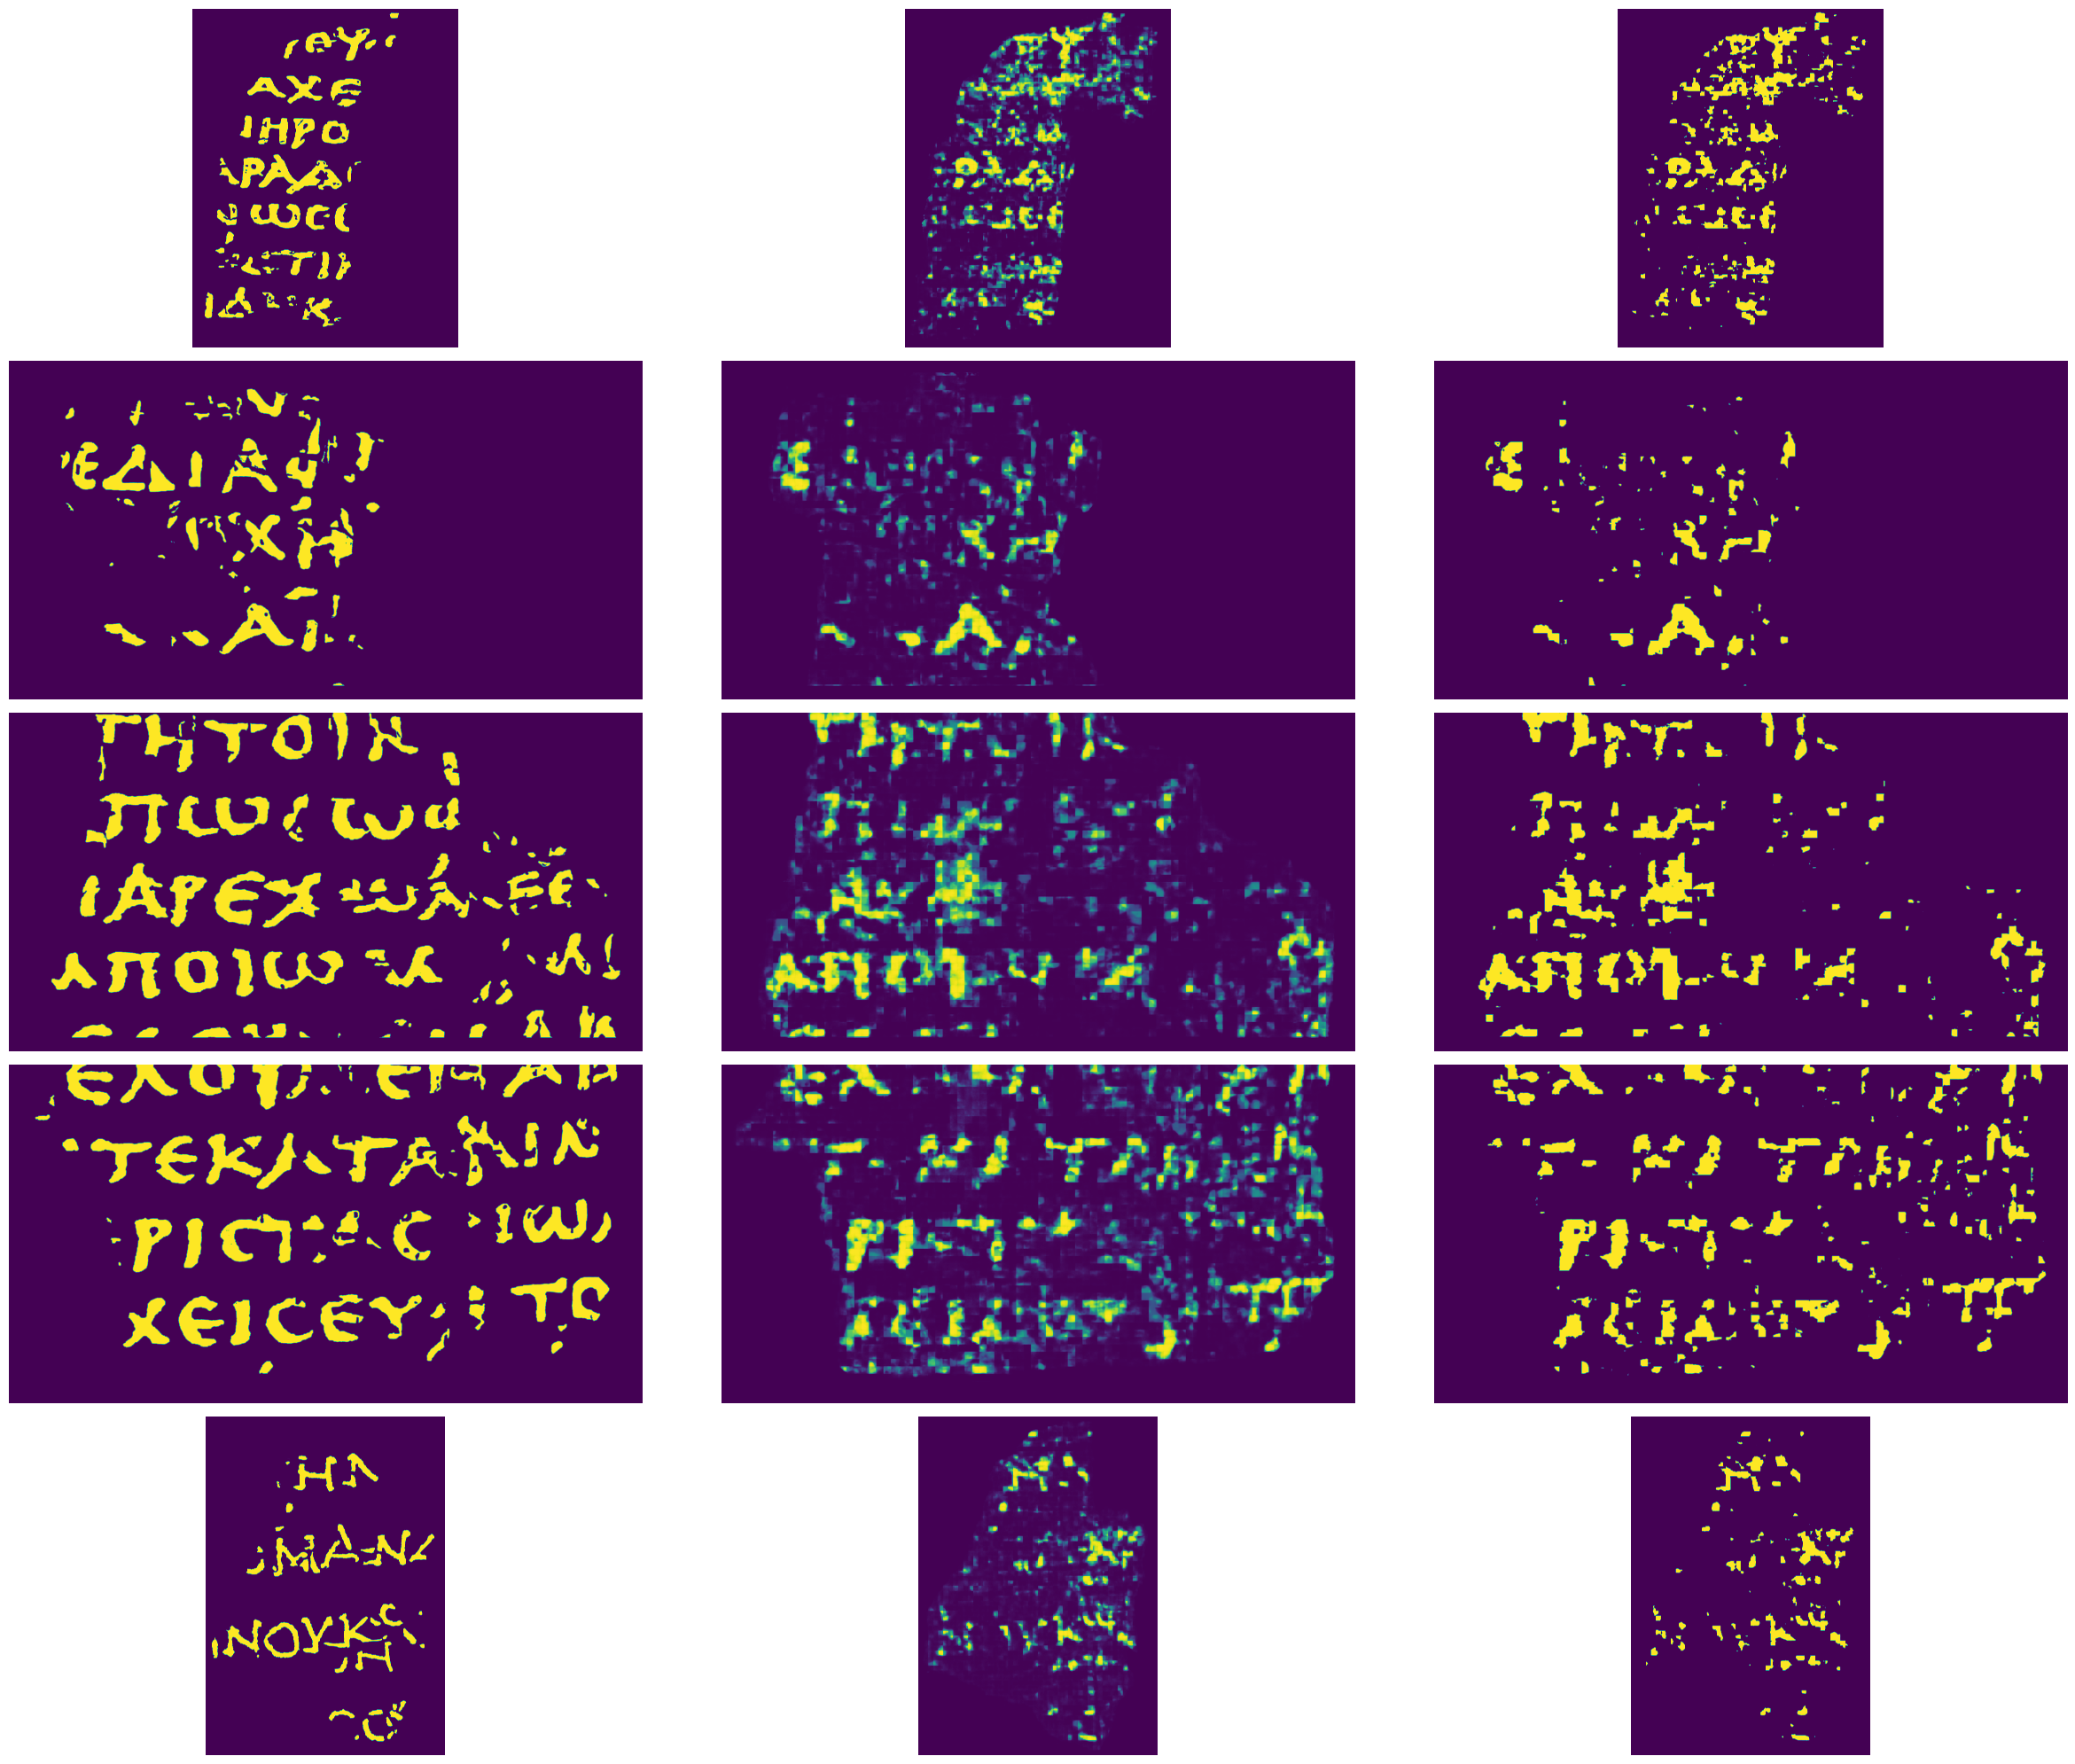

In [11]:
plot_inference(valid_label_gt_list, label_pred_list, CFG)